In [55]:
from typing import Optional
from omegaconf import DictConfig

import logging
import torch
import matplotlib.pyplot as plt

from tabularbench.core.enums import DatasetSize, ModelName, Task
from tabularbench.core.get_model import get_model
from tabularbench.core.get_trainer import get_trainer

from tabularbench.data.dataset_openml import OpenMLDataset
from tabularbench.results.run_metrics import RunMetrics
from tabularbench.utils.config_run import ConfigRun
from tabularbench.utils.set_seed import set_seed
from tabularbench.core.run_experiment import run_experiment


cfg = ConfigRun(
    output_dir = "output_run_experiment",
    device = torch.device("cuda:2"),
    model_name = ModelName.FOUNDATION,
    seed = 0,
    task = Task.CLASSIFICATION,
    dataset_size = DatasetSize.MEDIUM,
    openml_dataset_id = 44156,
    openml_dataset_name = "electricity",
    hyperparams = DictConfig({
        'n_features': 100,
        'n_classes': 10,
        'dim': 512,
        'n_layers': 12,
        'n_heads': 4,
        'attn_dropout': 0.0,
        'y_as_float_embedding': True,
        'linear_attention': False,
        'max_samples_support': 10000,
        'max_samples_query': 10000,
        'max_epochs': 0,
        'optimizer': 'adamw',
        'lr': 1.e-5,
        'weight_decay': 0,
        'lr_scheduler': False,
        'lr_scheduler_patience': 30,
        'early_stopping_patience': 40,
        'use_pretrained_weights': True,
        'n_ensembles': 1,
        'use_quantile_transformer': True,
        'use_feature_count_scaling': True
    })
)

foundation_forest_weights = 'outputs_done/foundation_forest_big_300k/weights/model_step_300000.pt'
foundation_pfn_weights = 'outputs_done/foundation_tabpfn_big/weights/model_step_500000.pt'
foundation_forest_128_weights = 'outputs_done/foundation_forest_dim_128/weights/model_step_300000.pt'
foundation_forest_256_weights = 'outputs_done/foundation_forest_dim_256/weights/model_step_300000.pt'

In [56]:
import numpy as np

dataset = OpenMLDataset(cfg.openml_dataset_id, cfg.task, cfg.dataset_size)
metrics = RunMetrics()

x_train, x_val, x_test, y_train, y_val, y_test, categorical_indicator = next(dataset.split_iterator())

# variables 0 and 3 are the most important ones (as selected by random forest feature importance)
features = [0, 3]

x_train = x_train[:, features]
x_val = x_val[:, features]
x_test = x_test[:, features]

In [57]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

coolwarm = plt.get_cmap('coolwarm')
coolwarm_trunc = truncate_colormap(coolwarm, 0.1, 0.9)

In [58]:
def irregularity_value(pred_grid):

    pred = pred_grid[:, :, 0] > 0.5

    pred_middle = pred[1:-1, 1:-1]
    pred_up = pred[:-2, 1:-1]
    pred_down = pred[2:, 1:-1]
    pred_left = pred[1:-1, :-2]
    pred_right = pred[1:-1, 2:]

    pred_diff = (pred_middle != pred_up) | (pred_middle != pred_down) | (pred_middle != pred_left) | (pred_middle != pred_right)
    return pred_diff.sum() / pred_diff.size

In [59]:
import einx

x1 = (np.arange(1000) / 100 - 0.5) * 6
x2 = (np.arange(1000) / 100 - 0.5) * 6

x_mesh1, x_mesh2 = np.meshgrid(x1, x2)

x_mesh1_col = einx.rearrange('h w -> (h w)', x_mesh1)
x_mesh2_col = einx.rearrange('h w -> (h w)', x_mesh2)

x_grid = np.zeros((1000000, x_test.shape[1]))
x_grid[:, 0] = x_mesh1_col
x_grid[:, 1] = x_mesh2_col

In [60]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, alpha=1e-4)
mlp.fit(x_train, y_train)
score_test_mlp = mlp.score(x_test, y_test)

score_test_mlp

0.7892333935380293

Text(0.5, 1.0, 'MLP (acc: 0.789, irreg: 0.0021)')

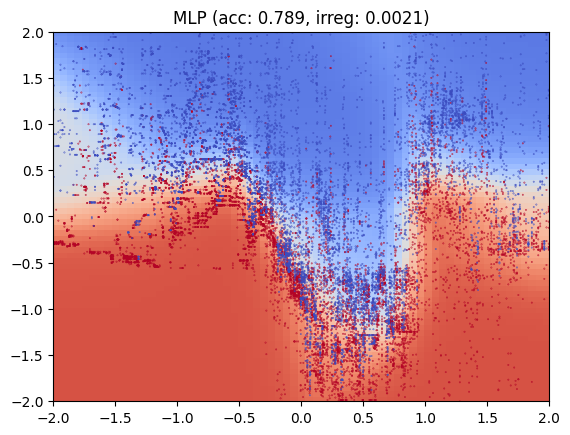

In [61]:
preds = mlp.predict_proba(x_grid)
preds = einx.rearrange('(h w) c -> h w c', preds, w=1000)

irreg_value = irregularity_value(preds)

plt.pcolormesh(x_mesh1, x_mesh2, preds[:, :, 0], cmap=coolwarm_trunc)
plt.scatter(x_test[:, 0], x_test[:, 1], c=1-y_test, s=0.1, cmap=coolwarm)
plt.ylim(-2, 2)
plt.xlim(-2, 2)

plt.title(f"MLP (acc: {score_test_mlp:.3f}, irreg: {irreg_value:.4f})")

In [62]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(x_train, y_train)
score_test_rf = clf.score(x_test, y_test)

score_test_rf


0.8693558097531607

In [63]:
clf.feature_importances_

array([0.41942146, 0.58057854])

Text(0.5, 1.0, 'Random Forest (acc: 0.869, irreg: 0.0067)')

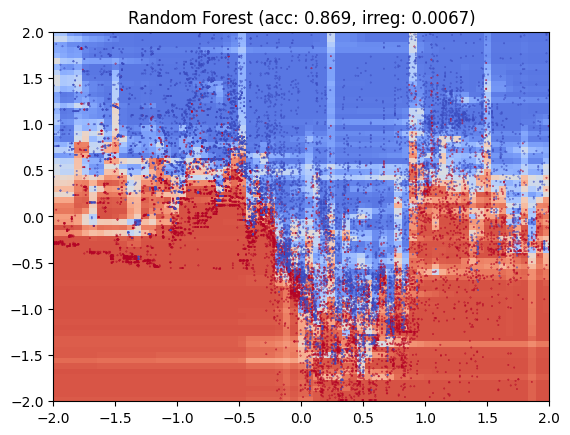

In [64]:
preds = clf.predict_proba(x_grid)
preds = einx.rearrange('(h w) c -> h w c', preds, w=1000)

irreg_value = irregularity_value(preds)

plt.pcolormesh(x_mesh1, x_mesh2, preds[:, :, 0], cmap=coolwarm_trunc)
plt.scatter(x_test[:, 0], x_test[:, 1], c=1-y_test, s=0.1, cmap=coolwarm)
plt.ylim(-2, 2)
plt.xlim(-2, 2)
plt.title(f"Random Forest (acc: {score_test_rf:.3f}, irreg: {irreg_value:.4f})")

In [65]:
cfg.hyperparams['path_to_weights'] = foundation_pfn_weights

model_pfn = get_model(cfg, x_train, y_train, categorical_indicator)
trainer_pfn = get_trainer(cfg, model_pfn)
trainer_pfn.train(x_train, y_train)

loss_train, score_train = trainer_pfn.test(x_train, y_train, x_train, y_train)
loss_val, score_val = trainer_pfn.test(x_train, y_train, x_val, y_val)
loss_test, score_test_tabpfn = trainer_pfn.test(x_train, y_train, x_test, y_test)

score_test_tabpfn

0.7853201031684875

In [66]:
preds_pfn_raw = trainer_pfn.predict(x_train, y_train, x_grid)
preds_pfn = einx.softmax('n [c]', preds_pfn_raw)
preds_pfn = einx.rearrange('(h w) c -> h w c', preds_pfn, w=1000)

irreg_value = irregularity_value(preds_pfn)


Text(0.5, 1.0, 'Foundation PFN ZeroShot (acc: 0.785, irreg: 0.0021)')

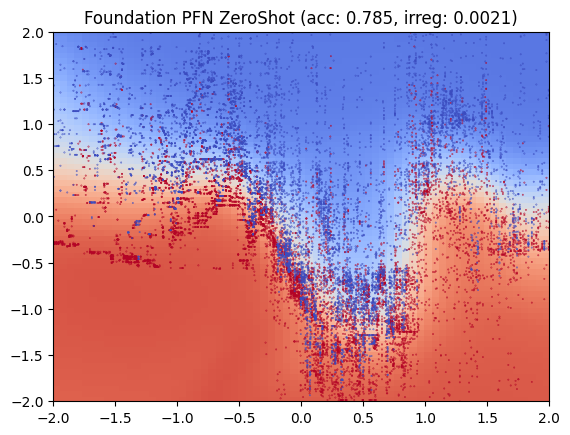

In [67]:
plt.pcolormesh(x_mesh1, x_mesh2, preds_pfn[:, :, 0], cmap=coolwarm_trunc)
plt.scatter(x_test[:, 0], x_test[:, 1], c=1-y_test, s=0.1, cmap=coolwarm)
plt.ylim(-2, 2)
plt.xlim(-2, 2)
plt.title(f"Foundation PFN ZeroShot (acc: {score_test_tabpfn:.3f}, irreg: {irreg_value:.4f})")

In [68]:
cfg.hyperparams['path_to_weights'] = foundation_forest_weights

model = get_model(cfg, x_train, y_train, categorical_indicator)
trainer = get_trainer(cfg, model)
trainer.train(x_train, y_train)

loss_train, score_train = trainer.test(x_train, y_train, x_train, y_train)
loss_val, score_val = trainer.test(x_train, y_train, x_val, y_val)
loss_test, score_test_forest = trainer.test(x_train, y_train, x_test, y_test)

score_test_forest

0.7679610848426819

In [69]:
preds_forest_raw = trainer.predict(x_train, y_train, x_grid)
preds_forest = einx.softmax('n [c]', preds_forest_raw)
preds_forest = einx.rearrange('(h w) c -> h w c', preds_forest, w=1000)

irreg_value = irregularity_value(preds_forest)

Text(0.5, 1.0, 'Foundation Forest ZeroShot (acc: 0.768, irreg: 0.0022)')

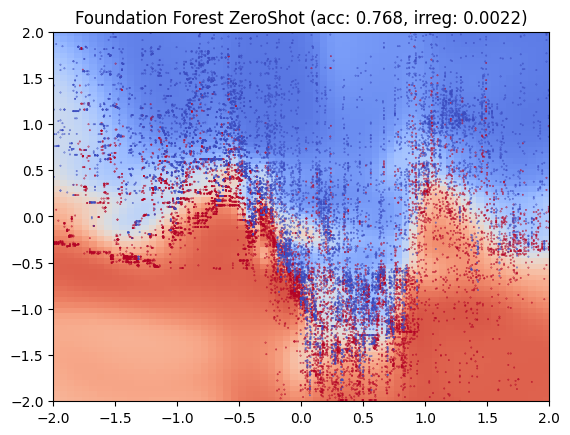

In [70]:
plt.pcolormesh(x_mesh1, x_mesh2, preds_forest[:, :, 0], cmap=coolwarm_trunc)
plt.scatter(x_test[:, 0], x_test[:, 1], c=1-y_test, s=0.1, cmap=coolwarm)
plt.ylim(-2, 2)
plt.xlim(-2, 2)

plt.title(f"Foundation Forest ZeroShot (acc: {score_test_forest:.3f}, irreg: {irreg_value:.4f})")

In [71]:
cfg.hyperparams['path_to_weights'] = foundation_pfn_weights
cfg.hyperparams['max_epochs'] = 300

model_pfn = get_model(cfg, x_train, y_train, categorical_indicator)
trainer_pfn = get_trainer(cfg, model_pfn)
trainer_pfn.train(x_train, y_train)

loss_train, score_train = trainer_pfn.test(x_train, y_train, x_train, y_train)
loss_val, score_val = trainer_pfn.test(x_train, y_train, x_val, y_val)
loss_test, score_test_tabpfn = trainer_pfn.test(x_train, y_train, x_test, y_test)

preds_pfn_raw = trainer_pfn.predict(x_train, y_train, x_grid)
preds_pfn = einx.softmax('n [c]', preds_pfn_raw)
preds_pfn = einx.rearrange('(h w) c -> h w c', preds_pfn, w=1000)

irreg_value = irregularity_value(preds_pfn)

plt.pcolormesh(x_mesh1, x_mesh2, preds_pfn[:, :, 0], cmap=coolwarm_trunc)
plt.scatter(x_test[:, 0], x_test[:, 1], c=1-y_test, s=0.1, cmap=coolwarm)
plt.ylim(-2, 2)
plt.xlim(-2, 2)
plt.title(f"Foundation PFN (acc: {score_test_tabpfn:.3f}, irreg: {irreg_value:.4f})")

2024-02-13 15:47:01.156 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 000 | Train loss: 0.4710 | Train score: 0.7669 | Val loss: 0.4185 | Val score: 0.8095
2024-02-13 15:47:02.510 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 001 | Train loss: 0.4516 | Train score: 0.7906 | Val loss: 0.4199 | Val score: 0.8055
2024-02-13 15:47:03.373 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 002 | Train loss: 0.4470 | Train score: 0.7912 | Val loss: 0.4168 | Val score: 0.8115
2024-02-13 15:47:04.729 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 003 | Train loss: 0.4300 | Train score: 0.7937 | Val loss: 0.4215 | Val score: 0.8075
2024-02-13 15:47:05.588 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 004 | Train loss: 0.4442 | Train score: 0.7906 | Val loss: 0.4221 | Val score: 0.8050
2024-02-13 15:47:06.447 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 005 | Train loss: 0.4355 | Train sco

2024-02-13 15:24:19.352 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 000 | Train loss: 0.4832 | Train score: 0.7556 | Val loss: 0.4572 | Val score: 0.7675
2024-02-13 15:24:20.697 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 001 | Train loss: 0.4586 | Train score: 0.7738 | Val loss: 0.4382 | Val score: 0.8015
2024-02-13 15:24:22.057 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 002 | Train loss: 0.4430 | Train score: 0.7919 | Val loss: 0.4369 | Val score: 0.7975
2024-02-13 15:24:23.413 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 003 | Train loss: 0.4385 | Train score: 0.7831 | Val loss: 0.4313 | Val score: 0.8025
2024-02-13 15:24:24.772 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 004 | Train loss: 0.4463 | Train score: 0.7844 | Val loss: 0.4311 | Val score: 0.8035
2024-02-13 15:24:26.130 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 005 | Train loss: 0.4138 | Train sco

Text(0.5, 1.0, 'Foundation Forest (accuracy: 0.801)')

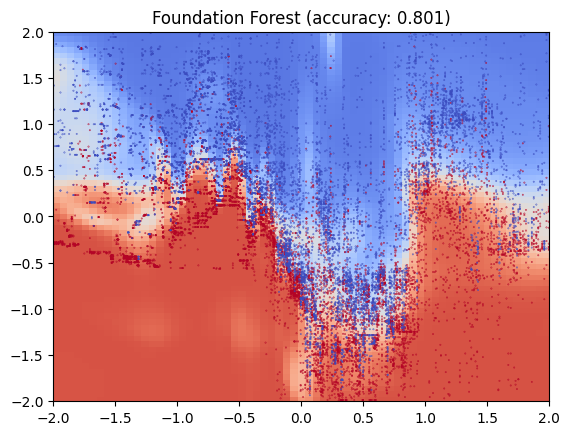

In [ ]:
cfg.hyperparams['path_to_weights'] = foundation_forest_weights
cfg.hyperparams['max_epochs'] = 300

model = get_model(cfg, x_train, y_train, categorical_indicator)
trainer = get_trainer(cfg, model)
trainer.train(x_train, y_train)

loss_train, score_train = trainer.test(x_train, y_train, x_train, y_train)
loss_val, score_val = trainer.test(x_train, y_train, x_val, y_val)
loss_test, score_test_forest = trainer.test(x_train, y_train, x_test, y_test)

preds_forest_raw = trainer.predict(x_train, y_train, x_grid)
preds_forest = einx.softmax('n [c]', preds_forest_raw)
preds_forest = einx.rearrange('(h w) c -> h w c', preds_forest, w=1000)

irreg_value = irregularity_value(preds_forest)

plt.pcolormesh(x_mesh1, x_mesh2, preds_forest[:, :, 0], cmap=coolwarm_trunc)
plt.scatter(x_test[:, 0], x_test[:, 1], c=1-y_test, s=0.1, cmap=coolwarm)
plt.ylim(-2, 2)
plt.xlim(-2, 2)

plt.title(f"Foundation Forest (acc: {score_test_forest:.3f}, irreg: {irreg_value:.4f})")

2024-02-13 15:28:53.459 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 000 | Train loss: 0.4543 | Train score: 0.7738 | Val loss: 0.4437 | Val score: 0.7700
2024-02-13 15:28:54.266 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 001 | Train loss: 0.4410 | Train score: 0.7856 | Val loss: 0.4497 | Val score: 0.7790
2024-02-13 15:28:54.930 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 002 | Train loss: 0.4454 | Train score: 0.7769 | Val loss: 0.4482 | Val score: 0.7795
2024-02-13 15:28:55.595 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 003 | Train loss: 0.4450 | Train score: 0.7906 | Val loss: 0.4446 | Val score: 0.7830
2024-02-13 15:28:56.259 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 004 | Train loss: 0.4431 | Train score: 0.7869 | Val loss: 0.4420 | Val score: 0.7825
2024-02-13 15:28:57.077 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 005 | Train loss: 0.4413 | Train sco

Text(0.5, 1.0, 'Foundation Forest 256 (accuracy: 0.800)')

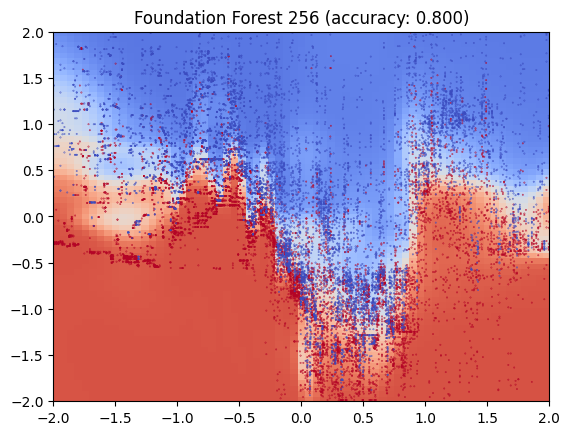

In [ ]:
cfg.hyperparams['path_to_weights'] = foundation_forest_256_weights
cfg.hyperparams['max_epochs'] = 300
cfg.hyperparams['dim'] = 256

model = get_model(cfg, x_train, y_train, categorical_indicator)
trainer = get_trainer(cfg, model)
trainer.train(x_train, y_train)

loss_train, score_train = trainer.test(x_train, y_train, x_train, y_train)
loss_val, score_val = trainer.test(x_train, y_train, x_val, y_val)
loss_test, score_test_forest = trainer.test(x_train, y_train, x_test, y_test)

preds_forest_raw = trainer.predict(x_train, y_train, x_grid)
preds_forest = einx.softmax('n [c]', preds_forest_raw)
preds_forest = einx.rearrange('(h w) c -> h w c', preds_forest, w=1000)

irreg_value = irregularity_value(preds_forest)

plt.pcolormesh(x_mesh1, x_mesh2, preds_forest[:, :, 0], cmap=coolwarm_trunc)
plt.scatter(x_test[:, 0], x_test[:, 1], c=1-y_test, s=0.1, cmap=coolwarm)
plt.ylim(-2, 2)
plt.xlim(-2, 2)

plt.title(f"Foundation Forest 256 (acc: {score_test_forest:.3f}, irreg: {irreg_value:.4f})")

2024-02-13 15:31:19.321 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 000 | Train loss: 0.4509 | Train score: 0.7781 | Val loss: 0.4435 | Val score: 0.7865
2024-02-13 15:31:19.981 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 001 | Train loss: 0.4490 | Train score: 0.7881 | Val loss: 0.4388 | Val score: 0.7880
2024-02-13 15:31:20.639 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 002 | Train loss: 0.4611 | Train score: 0.7812 | Val loss: 0.4380 | Val score: 0.7925
2024-02-13 15:31:21.299 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 003 | Train loss: 0.4184 | Train score: 0.7994 | Val loss: 0.4394 | Val score: 0.7910
2024-02-13 15:31:21.912 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 004 | Train loss: 0.4185 | Train score: 0.8069 | Val loss: 0.4396 | Val score: 0.7935
2024-02-13 15:31:22.534 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 005 | Train loss: 0.4285 | Train sco

Text(0.5, 1.0, 'Foundation Forest 128 (accuracy: 0.800)')

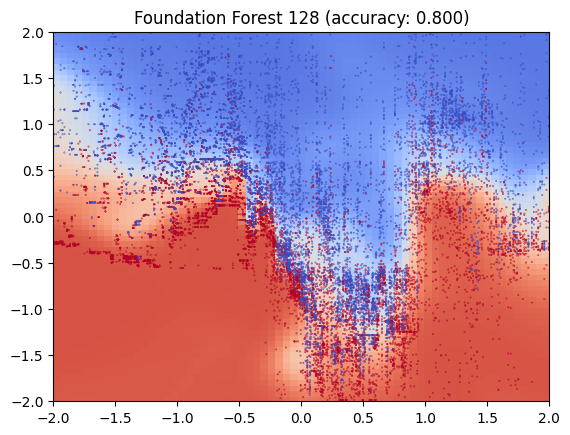

In [ ]:
cfg.hyperparams['path_to_weights'] = foundation_forest_128_weights
cfg.hyperparams['max_epochs'] = 300
cfg.hyperparams['dim'] = 128

model = get_model(cfg, x_train, y_train, categorical_indicator)
trainer = get_trainer(cfg, model)
trainer.train(x_train, y_train)

loss_train, score_train = trainer.test(x_train, y_train, x_train, y_train)
loss_val, score_val = trainer.test(x_train, y_train, x_val, y_val)
loss_test, score_test_forest = trainer.test(x_train, y_train, x_test, y_test)

preds_forest_raw = trainer.predict(x_train, y_train, x_grid)
preds_forest = einx.softmax('n [c]', preds_forest_raw)
preds_forest = einx.rearrange('(h w) c -> h w c', preds_forest, w=1000)

irreg_value = irregularity_value(preds_forest)

plt.pcolormesh(x_mesh1, x_mesh2, preds_forest[:, :, 0], cmap=coolwarm_trunc)
plt.scatter(x_test[:, 0], x_test[:, 1], c=1-y_test, s=0.1, cmap=coolwarm)
plt.ylim(-2, 2)
plt.xlim(-2, 2)

plt.title(f"Foundation Forest 128 (acc: {score_test_forest:.3f}, irreg: {irreg_value:.4f})")